# Exemples of some packages in Julia 

## DifferentialEquiations.jl


Julia's DifferentialEquiations.jl is the [best](https://docs.sciml.ai/SciMLBenchmarksOutput/stable/MultiLanguage/ode_wrapper_packages/) differential equation solver in the world. 

For this example, we will just explore ordinary differential equations (ODEs) and the sub-package `OrdinaryDiffEq.jl`.

### Lorentz Attractor

In [1]:
using Pkg
Pkg.activate(".")
# Pkg.add("StaticArrays")
# Pkg.add("Unitful")
# Pkg.add("Statistics")

using OrdinaryDiffEq, StaticArrays 

  Activating project at `c:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice`


In [7]:
function Lorentz(u, p, t)
    x, y, z = u
    σ, ρ, β = p
    ẋ = σ * (y - x)
    ẏ = x * (ρ - z) - y
    ż = x * y - β * z
    return SVector(ẋ, ẏ, ż)
end

Lorentz (generic function with 2 methods)

Or you can do it inplace:

In [3]:
function Lorentz!(du, u, p, t)
    x, y, z = u
    σ, ρ, β = p
    du[1] = σ*(y - x)
    du[2] = x*(ρ - z) - y
    du[3] = x*y - β*z
end

Lorentz! (generic function with 1 method)

In [8]:
u₀ = SVector(10.0,10.0,10.0)
p = [10,28,8/3]
tspan = (0.0,100.0)

(0.0, 100.0)

In [11]:
prob = ODEProblem(Lorentz,u₀, (0.0,100.0),p)

ODEProblem with uType SVector{3, Float64} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: 3-element SVector{3, Float64} with indices SOneTo(3):
 10.0
 10.0
 10.0

In [12]:
alg = Vern9()
sol = solve(prob;alg=alg);

In [13]:
(sol.t[3],sol.u[3])

(0.1728394373814634, [16.260683890272716, 11.987742957503144, 40.86665186055775])

You can also access it like this: `sol[i,j]` where `i` is the variable index and `j` is the time index.

In [14]:
sol[:,3]

3-element SVector{3, Float64} with indices SOneTo(3):
 16.260683890272716
 11.987742957503144
 40.86665186055775

Plotting the solution is easy:

In [15]:
xs = sol[1,:]
ys = sol[2,:]
zs = sol[3,:];
points = [xs ys zs];

In [16]:
using CairoMakie
# Pkg.add("GLMakie")
# using GLMakie # to be able to rotate

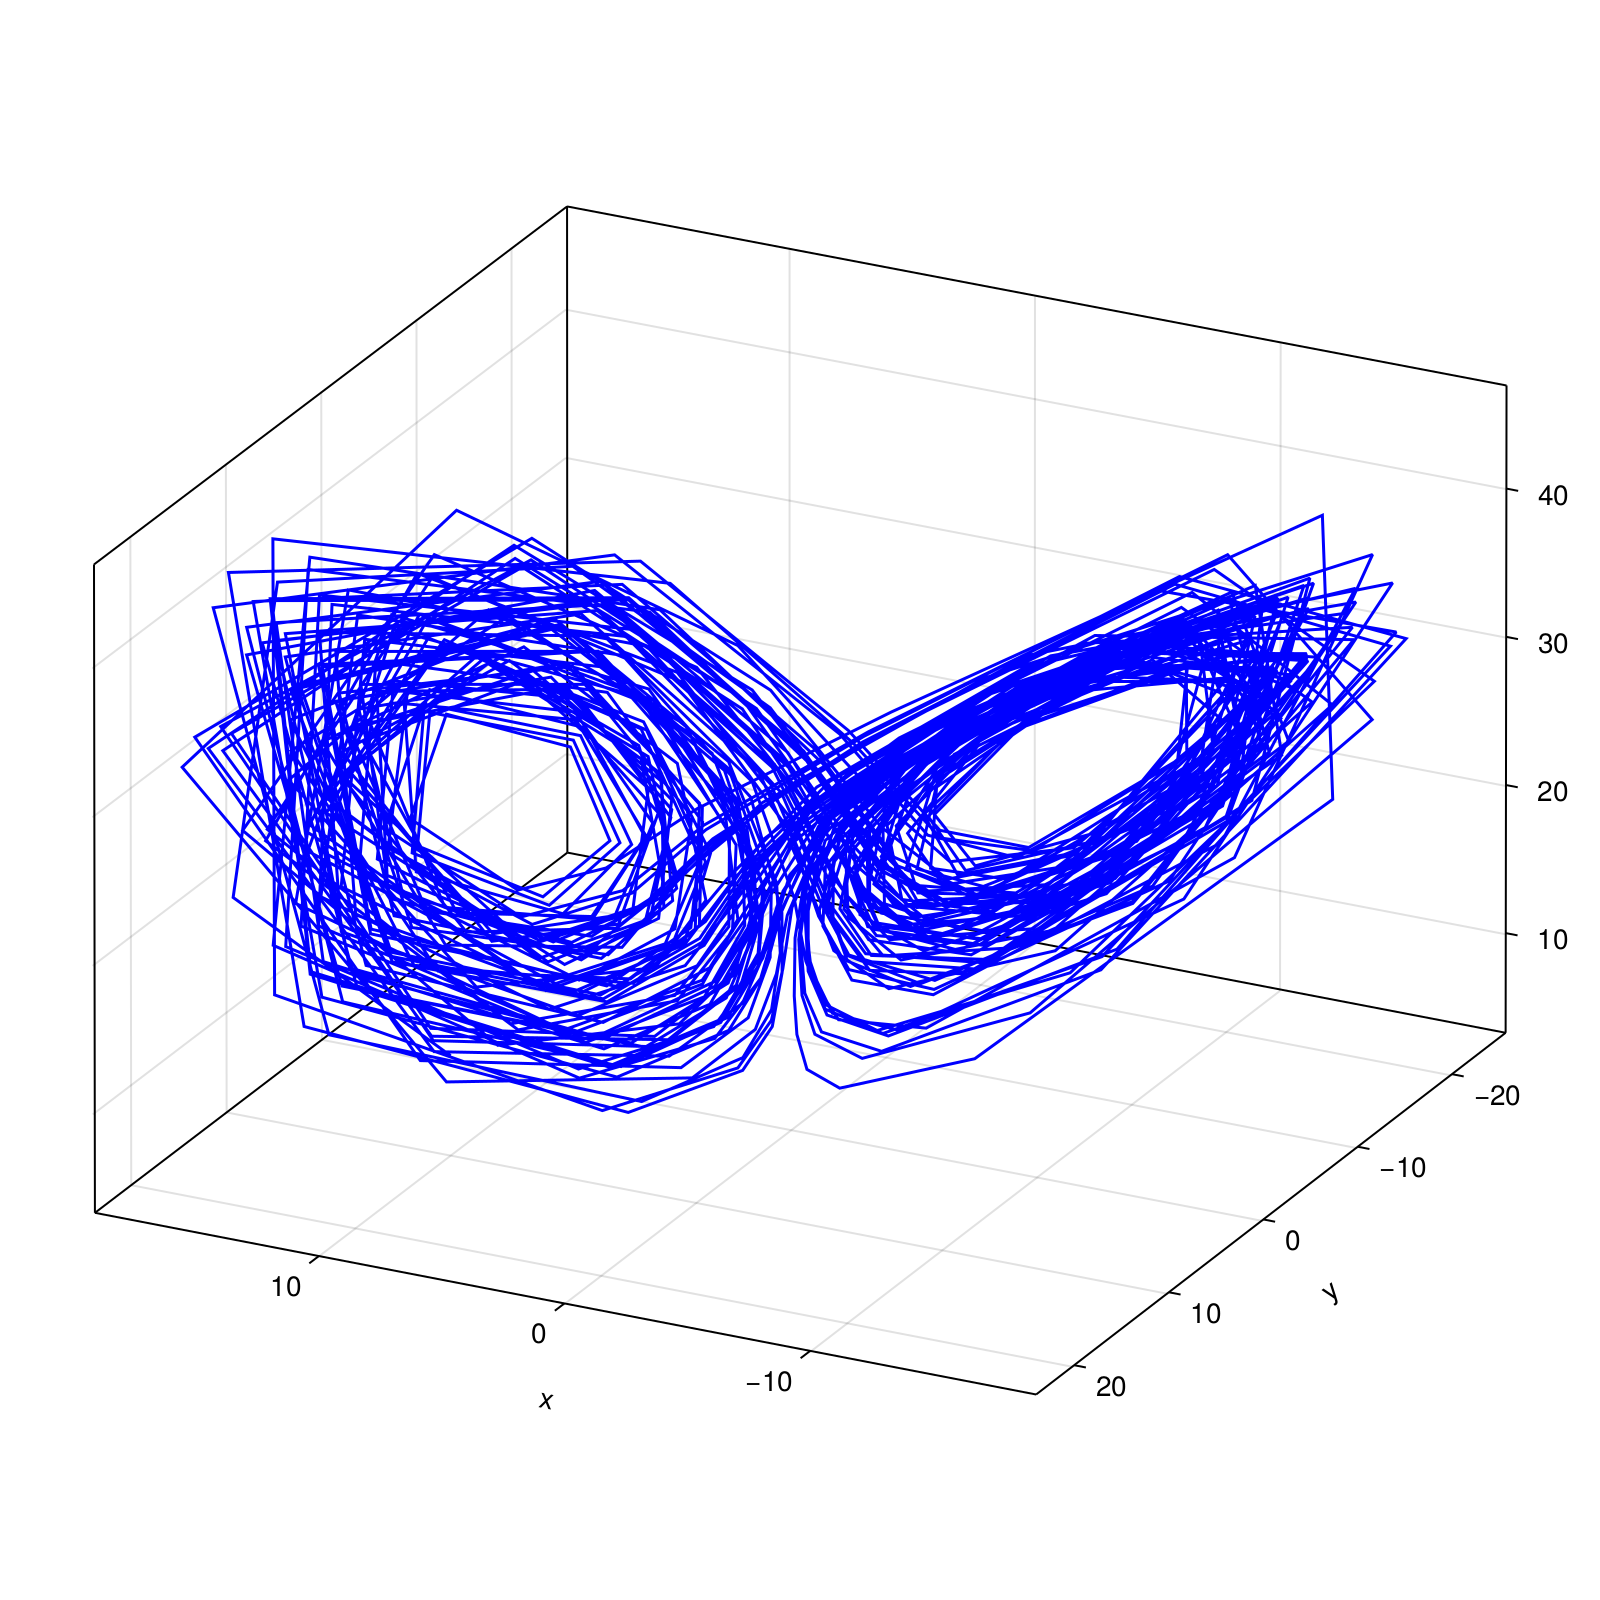

In [17]:
fig = Figure(size=(800,800))
ax = Axis3(fig[1, 1])
lines!(ax, xs, ys, zs, color = :blue)
ax.azimuth = 90
fig

This is ugly, luckily it is very easy to interpolate using the ode solution object:

In [18]:
sol(5.5) # evaluates the solution at t=5.5

3-element SVector{3, Float64} with indices SOneTo(3):
  6.800630896051432
 -1.9596754839675494
 34.15163918515632

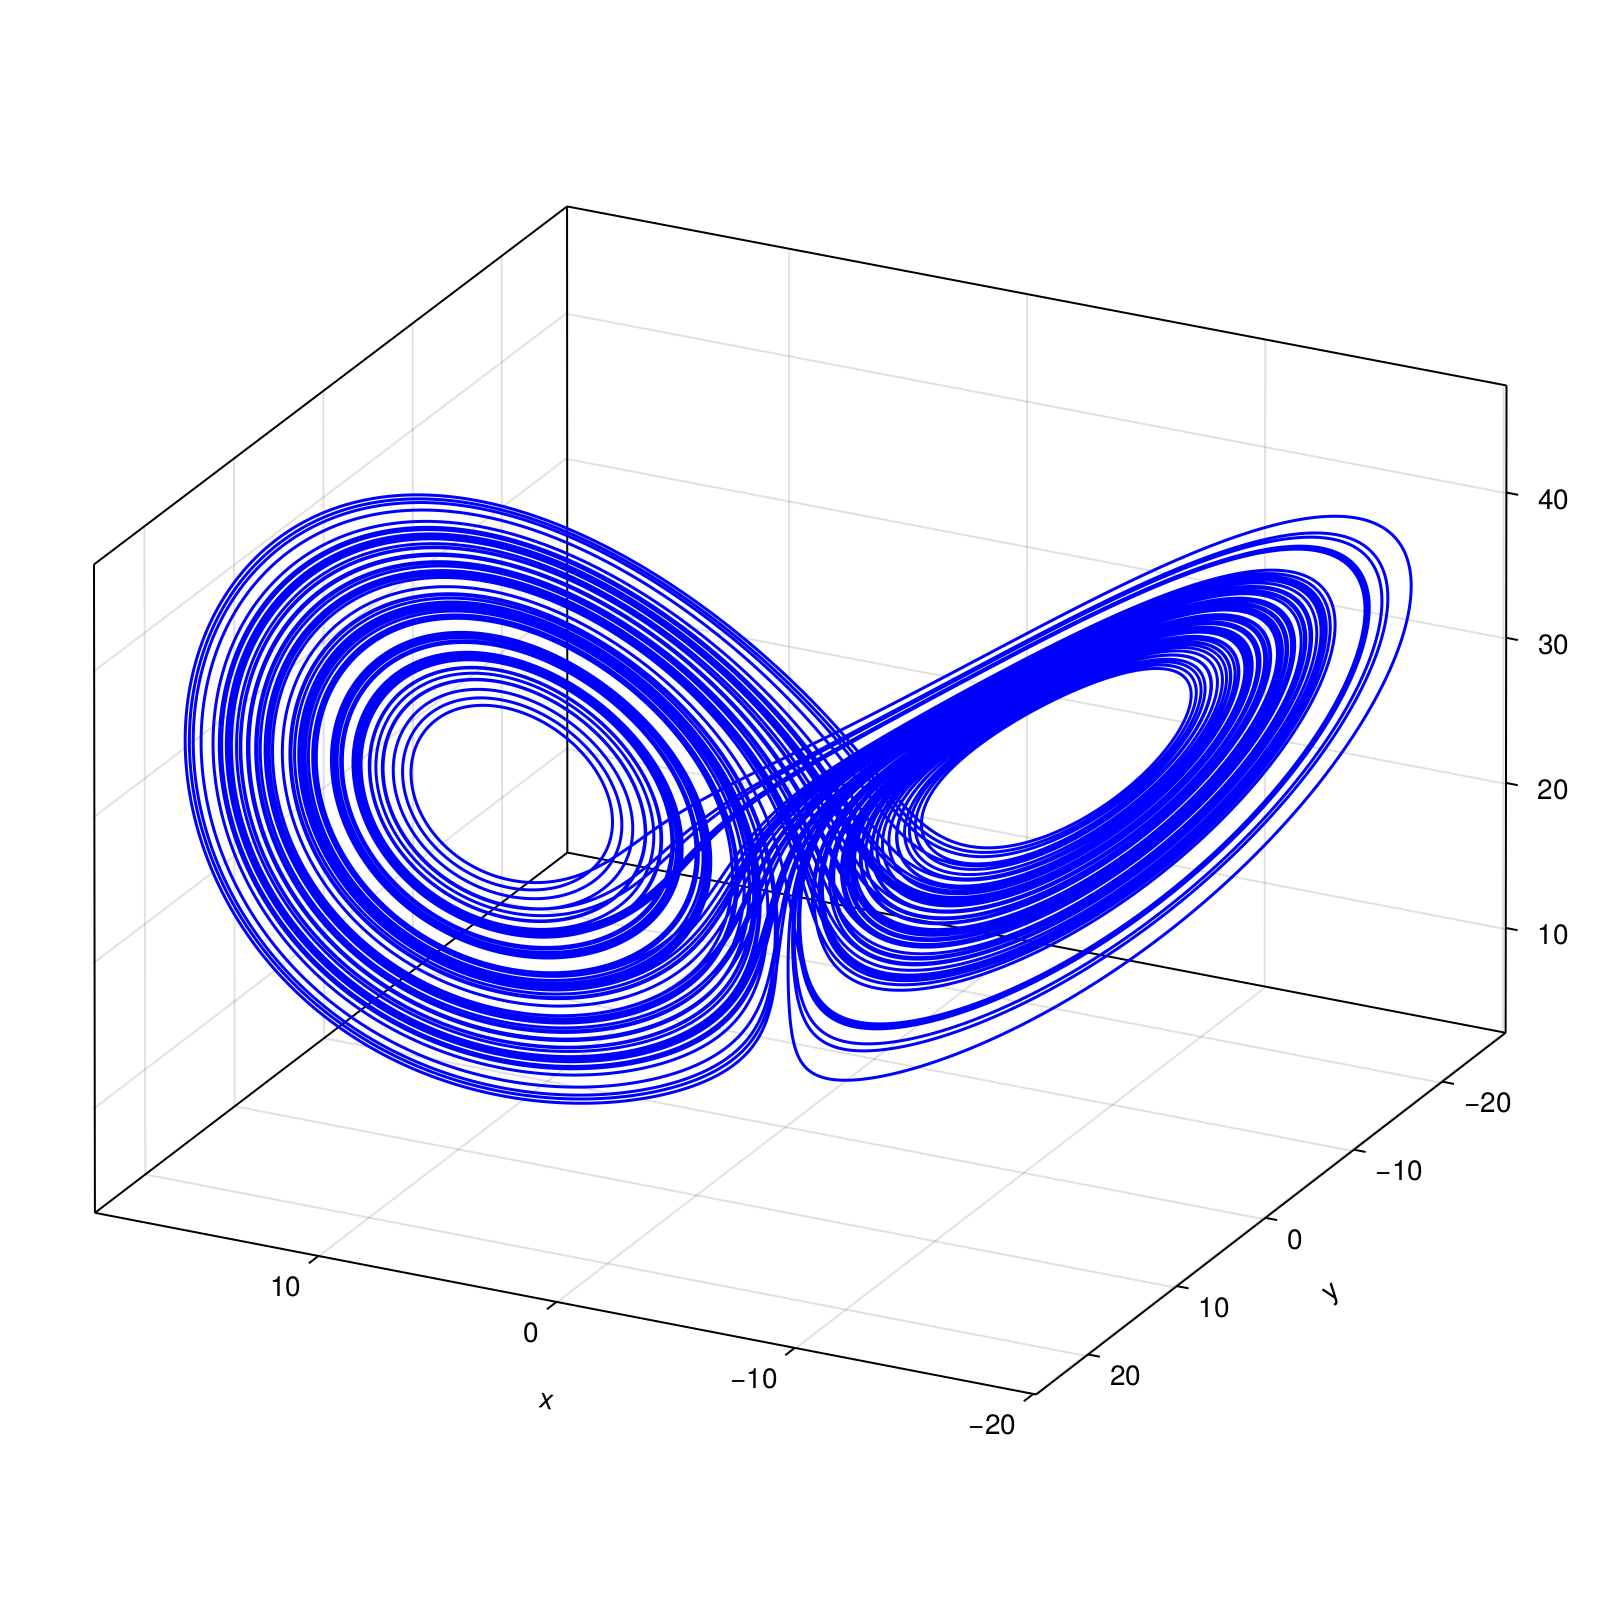

In [19]:
t = 1:0.001:100
Points = zeros(length(t),3)
for (i,τ) ∈ enumerate(t)
    Points[i,:] = sol(τ)
end

fig = Figure(size=(800,800))
ax = Axis3(fig[1, 1])
lines!(ax, Points, color = :blue)
ax.azimuth = 90
fig

### Numbers with uncertainties

The thing that is nice with Julia is that almost all packages are compatible with each other. For example, we can use the `OrdinaryDiffEq.jl` package with the `Measurements.jl` package to solve ODEs with uncertainties. Even tho the `Measurements.jl` package and the `OrdinaryDiffEq.jl` package are not made to work together, they still do.

In [14]:
Pkg.add("Measurements")
using Measurements

   Resolving package versions...


  No Changes to `C:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Project.toml`
  No Changes to `C:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Manifest.toml`


In [15]:
a = 5.0 ± 0.1
b = 3.0 ± 0.2

3.0 ± 0.2

In [16]:
sqrt(a^2 + b^2)

5.83 ± 0.13

#### What is this sorcery?

Measurements.jl uses a type called `Measurement` to store numbers with uncertainties. It used the `+,-,*,/` operators to propagate the uncertainties using linear error propagation. so now any package that uses the `+,-,*,/` operators will work with the `Measurement` type.

Let's look back at the Lorenz attractor example:

In [17]:
u2₀ = SVector(10.0 ± 0.1,10.0 ± 0.1,10.0 ± 0.1)

3-element SVector{3, Measurement{Float64}} with indices SOneTo(3):
 10.0 ± 0.1
 10.0 ± 0.1
 10.0 ± 0.1

In [18]:
prob2 = ODEProblem(Lorentz,u2₀,tspan,p) 

SciMLBase.TooFewArgumentsError: All methods for the model function `f` had too few arguments. For example,
an ODEProblem `f` must define either `f(u,p,t)` or `f(du,u,p,t)`. This error
can be thrown if you define an ODE model for example as `f(u,t)`. The parameters
`p` are not optional in the definition of `f`! For more information on the required
number of arguments for the function you were defining, consult the documentation
for the `SciMLProblem` or `SciMLFunction` type that was being constructed.

For example, here is the no parameter Lorenz equation. The two valid versions
are out of place:

```julia
function lorenz(u,p,t)
  du1 = 10.0*(u[2]-u[1])
  du2 = u[1]*(28.0-u[3]) - u[2]
  du3 = u[1]*u[2] - 8/3*u[3]
  [du1,du2,du3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz,u0,tspan)
```

and in-place:

```julia
function lorenz!(du,u,p,t)
  du[1] = 10.0*(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - 8/3*u[3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz!,u0,tspan)
```

Offending function: f
Methods:
# 1 method for generic function "Lorentz" from Main:
 [1] Lorentz(u, p)
     @ c:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Ecosystem.ipynb:1


In [19]:
sol2 = solve(prob2;alg=alg);

UndefVarError: UndefVarError: `prob2` not defined

In [20]:
t = 0:0.05:5
Xs = [sol2(τ)[1] for τ ∈ t]
Xval = Measurements.value.(Xs)
Xerr = Measurements.uncertainty.(Xs)

UndefVarError: UndefVarError: `sol2` not defined

In [21]:
fig = Figure()
ax = Axis(fig[1, 1])
lines!(ax, t, Xval)
fill_between!(ax, t, Xval - Xerr, Xval + Xerr, color = (:blue, 0.2))
fig

UndefVarError: UndefVarError: `Xval` not defined

### Event Handling

What if we want the function to some arbitrary thing when a condition is met? 

You can use ContinuousCallback to do this.

In [22]:
condition(u,t,integrator) = (u[2] - 0) # When the RHS is zero, the event is triggered

function affect!(integrator)
    u = integrator.u
    integrator.u = (u[1],u[2],.9u[3])
end
# if a value is deviating a lot, you can bring it back by a percentage

affect! (generic function with 1 method)

In [23]:
cb = ContinuousCallback(condition,affect!)

ContinuousCallback{typeof(condition), typeof(affect!), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

In [24]:
prob3 = ODEProblem(Lorentz,u₀,tspan,p)
sol = solve(prob3,alg=alg, callback = cb);

SciMLBase.TooFewArgumentsError: All methods for the model function `f` had too few arguments. For example,
an ODEProblem `f` must define either `f(u,p,t)` or `f(du,u,p,t)`. This error
can be thrown if you define an ODE model for example as `f(u,t)`. The parameters
`p` are not optional in the definition of `f`! For more information on the required
number of arguments for the function you were defining, consult the documentation
for the `SciMLProblem` or `SciMLFunction` type that was being constructed.

For example, here is the no parameter Lorenz equation. The two valid versions
are out of place:

```julia
function lorenz(u,p,t)
  du1 = 10.0*(u[2]-u[1])
  du2 = u[1]*(28.0-u[3]) - u[2]
  du3 = u[1]*u[2] - 8/3*u[3]
  [du1,du2,du3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz,u0,tspan)
```

and in-place:

```julia
function lorenz!(du,u,p,t)
  du[1] = 10.0*(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - 8/3*u[3]
 end
 u0 = [1.0;0.0;0.0]
 tspan = (0.0,100.0)
 prob = ODEProblem(lorenz!,u0,tspan)
```

Offending function: f
Methods:
# 1 method for generic function "Lorentz" from Main:
 [1] Lorentz(u, p)
     @ c:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Ecosystem.ipynb:1


In [25]:
t = 0:0.01:50
Points = zeros(length(t),3)
for (i,τ) ∈ enumerate(t)
    Points[i,:] = sol(τ)
end

UndefVarError: UndefVarError: `sol` not defined

In [26]:
fig = Figure()
ax = Axis3(fig[1, 1])
lines!(ax, Points, color = :blue)
ax.azimuth = 90
fig

## DynamicalSystems.jl

This is an extention of the DifferentialEquiations.jl package. It is used to analyze dynamical systems. It can be used to compute many things for example: 

In [27]:
using Pkg
Pkg.add("DynamicalSystems")
using DynamicalSystems

   Resolving package versions...


  No Changes to `C:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Project.toml`
  No Changes to `C:\Users\USAID\Documents\2023-2024\phys 218\NonLinearDynamics\Julia Practice\Manifest.toml`


In [ ]:
lorenz = ContinuousDynamicalSystem(Lorentz,u₀,p)

Or if you just need the max lyapunov exponent:

In [ ]:
lyapunov(lorenz, 1000.0) # 2nd argument is the time to evolve the system

Or say you want the poincare section:

In [ ]:
plane = (2,0.0)  # When variable 2 is zero
psos = poincaresos(lorenz,plane,1000.0) # 2nd argument is the time to evolve the system

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "x", ylabel = "z")
scatter!(ax, psos[:,1], psos[:,3], color = :blue)
fig

## Distributions.jl

This package is used to generate and fit distributions.

In [ ]:
Pkg.add("Distributions")
using Distributions

In [ ]:
x = -1:0.01:1;

Some examples of distributions:

In [ ]:
N = Normal(0,0.25)

In [ ]:
lines(x, pdf.(N,x))

In [ ]:
C = Cauchy(0.5,0.25) # Cauchy distribution also known as Lorentzian

In [ ]:
lines(x, pdf.(C,x))

In [ ]:
rand(C)

In [ ]:
rand(C,10,10)

In [ ]:
x = randn(5000)
hist(x)

In [ ]:
best_fit = fit(Normal,x)

In [ ]:
l = -3.5:0.01:3.5
fig = Figure()
ax = Axis(fig[1, 1])
hist!(ax, x, normalization = :pdf)
lines!(ax, l, pdf.(best_fit,l), color = :red)
fig

In [ ]:
mean(best_fit), std(best_fit)

## DataFrame.jl

This package is used to store data in a table format. It is very similar to the pandas package in python.

In [ ]:
Pkg.add("DataFrames")
using DataFrames, CSV

In [ ]:
german = DataFrame(CSV.File(
    joinpath(dirname(pathof(DataFrames)), 
    "../docs/src/assets/german.csv")
))
german[1:5,:]

In [ ]:
german[1:5,["Checking account","Duration","Credit amount"]]

In [ ]:
select!(german, Not(:Purpose))

In [ ]:
Pkg.add("Query")
using Query

In [ ]:
q = @from row in german begin
    @where row.Age > 25
    @select {row.id,row.Age, row.Job, S = ((row.Sex == "male" ) ? 'M' : 'F')}
    @collect DataFrame
end
q[1:5,:]

## Using Python packages!

What is very nice in Julia is that you can use Python packages. For example, we can use the `scipy` package very easily by using the `PyCall.jl` package.

In [ ]:
Pkg.add("PyCall")
using PyCall

In [ ]:
np = pyimport("numpy")
sp = pyimport("scipy")
pd = pyimport("pandas")

In [ ]:
np.arange(10)